[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/nguyenphuvinhtoan/SpecializedProject_HK231/blob/main/CIHP_InstanceSegmentation_FormatYOLOv8.ipynb)

# Download Dataset for YOLOv8

### Download Dataset từ nguồn của tác giả

#### Tạo thư mục data để chứa ảnh và dữ liệu liên quan đến dataset tải về dữ liệu

In [ ]:
!mkdir data
%cd data

/content/data


In [ ]:
# images.zip
!gdown https://drive.google.com/uc?id=1HltDOSqdk3YMNn8de76CekuZ2rqFWKLl
# Uncomment block below if need json files
"""
# CIHP_train.json
!gdown https://drive.google.com/uc?id=1aPOg90kVwGYseCvZ7JU1TXFfdCJhoNZ9
# CIHP_val.json
!gdown https://drive.google.com/uc?id=1npjmI5RjoYQ7Y-jdvHsdwiVBcOh64IfY
# CIHP_test.json
!gdown https://drive.google.com/uc?id=1D_qsRga05YC89pCmy6wbKn-IKhvLMOY_
"""

Downloading...
From: https://drive.google.com/uc?id=1HltDOSqdk3YMNn8de76CekuZ2rqFWKLl
To: /content/data/images.zip
100% 1.45G/1.45G [00:25<00:00, 56.8MB/s]


'\n# CIHP_train.json\n!gdown https://drive.google.com/uc?id=1aPOg90kVwGYseCvZ7JU1TXFfdCJhoNZ9\n# CIHP_val.json\n!gdown https://drive.google.com/uc?id=1npjmI5RjoYQ7Y-jdvHsdwiVBcOh64IfY\n# CIHP_test.json\n!gdown https://drive.google.com/uc?id=1D_qsRga05YC89pCmy6wbKn-IKhvLMOY_\n'

In [ ]:
# Unzip images.zip
!unzip -qq images.zip

In [ ]:
# Remove unused images.zip after extraction
!rm -rf images.zip

In [ ]:
# Download test_image
!gdown https://drive.google.com/uc?id=1BAjkBvBU_QGGE-YEAY445hRstz_yDSCg

Downloading...
From: https://drive.google.com/uc?id=1BAjkBvBU_QGGE-YEAY445hRstz_yDSCg
To: /content/data/CIHP_test_img.zip
100% 156M/156M [00:07<00:00, 21.5MB/s]


In [ ]:
# Unzip CIHP_test_img.zip
!unzip -qq CIHP_test_img.zip

In [ ]:
# Remove unused CIHP_test_img.zip after extraction
!rm -rf CIHP_test_img.zip

### Download Detection labels cho YOLOv8

In [ ]:
# Tải label cho detection YOLOv8
!gdown https://drive.google.com/uc?id=1zfNhwCVg7KdmHFHHSwiHRDAWyObyHuRy

Downloading...
From: https://drive.google.com/uc?id=1zfNhwCVg7KdmHFHHSwiHRDAWyObyHuRy
To: /content/data/CIHP_YOLOv8_Detection_Label.zip
100% 7.96M/7.96M [00:00<00:00, 24.1MB/s]


In [ ]:
# Unzip CIHP_YOLOv8_Detection_Label.zip
!unzip -qq CIHP_YOLOv8_Detection_Label.zip

In [ ]:
# Remove unused CIHP_YOLOv8_Detection_Label after extraction
!rm -rf CIHP_YOLOv8_Detection_Label.zip

In [ ]:
# Di chuyển ra lại thư mục /content
%cd ..

/content


# Create Segmentation Label for YOLOv8

## Import libraries

In [ ]:
import numpy as np
import cv2
from google.colab.patches import cv2_imshow
import math
from random import randint

## Hàm để decode label

In [ ]:
# colour map
labels_decoder = ["Background", "Hat", "Hair", "Glove", "Sunglasses", "UpperClothes", "Dress", "Coat", "Socks", "Pants", "Torso-skin", "Scarf", "Skirt", "Face", "Left-arm", "Right-arm", "Left-leg", "Right-leg", "Left-shoe", "Right-shoe", "Person"]
label_colours = [(0,0,0)
                , (128,0,0), (255,0,0), (0,85,0), (170,0,51), (255,85,0), (0,0,85), (0,119,221), (85,85,0), (0,85,85), (85,51,0), (52,86,128), (0,128,0)
                , (0,0,255), (51,170,221), (0,255,255), (85,255,170), (170,255,85), (255,255,0), (255,170,0)]

In [ ]:
def decode_labels(image):
    h, w = image.shape
    r, g ,b = [], [] , []
    for i in range(h):
        for j in range(w):
            x,y,z = label_colours[image[i,j]]
            r.append(x)
            g.append(y)
            b.append(z)
    r = np.array(r, dtype=np.uint8).reshape((h,w))
    g = np.array(g, dtype=np.uint8).reshape((h,w))
    b = np.array(b, dtype=np.uint8).reshape((h,w))
    return cv2.merge((b,g,r))

def merge_parsing(image, label):
    h,w,c = image.shape
    r,g,b = [], [], []
    for i in range(h):
        for j in range(w):
            if label[i,j,0] != 0 or label[i,j,1] != 0 or label[i,j,2] != 0:
                r.append(label[i,j,0])
                g.append(label[i,j,1])
                b.append(label[i,j,2])
            else:
                r.append(image[i,j,0])
                g.append(image[i,j,1])
                b.append(image[i,j,2])
    r = np.array(r, dtype=np.uint8).reshape((h,w))
    g = np.array(g, dtype=np.uint8).reshape((h,w))
    b = np.array(b, dtype=np.uint8).reshape((h,w))
    return cv2.merge((r,g,b))

## Hàm để vẽ label-YOLOv8 lên ảnh tương ứng

In [ ]:
# Hàm draw_label_YOLOv8 nhận vào (đường dẫn cho ảnh, đường dẫn cho file annotation, và flag fillPoly)
# fillPoly == True để vẽ mask cho objects
# fillPoly == False để vẽ polygon bao quanh objects
def draw_label_YOLOv8(image_path, annot_path, fillPoly=False):
    with open(annot_path, 'r') as f:
        labels = f.read().splitlines()
    img = cv2.imread(image_path)
    h,w = img.shape[:2]

    for label in labels:
        class_id, *poly = label.split(' ')

        poly = np.asarray(poly,dtype=np.float16).reshape(-1,2) # Read poly, reshape
        poly *= [w,h] # Unscale

        if fillPoly:
            if class_id == "20":    # Pass all person
                continue
            cv2.fillPoly(img, [poly.astype('int')], (randint(0,255),randint(0,255),randint(0,255)), cv2.LINE_AA) # Draw mask
        else:
            cv2.polylines(img, [poly.astype('int')], True, (randint(0,255),randint(0,255),randint(0,255)), 2) # Draw Poly Lines
    cv2_imshow(img)

## Hàm tạo và vẽ bouding box format (cx,cy,w,h)

In [ ]:
def create_anchor_pos(image):
    # height and width of image
    h, w = image.shape
    # Top-left and right-bottom position
    min_x, min_y, max_x, max_y = w, h, 0, 0
    for i in range(h):
        for j in range(w):
            if image[i,j] != 0:
                if j < min_x: min_x = j
                if i < min_y: min_y = i
                if j > max_x: max_x = j
                if i > max_y: max_y = i
    # Use block below to padding bounding box
    """
    padding = 0
    min_x -= padding
    min_y -= padding
    max_x += padding
    max_y += padding
    """
    # Normalize position
    min_x /= w
    max_x /= w
    min_y /= h
    max_y /= h
    # Return anchor-box (center_x, center_y, width, height)
    return (min_x+max_x)/2.0, (min_y+max_y)/2.0, max_x-min_x, max_y-min_y

def draw_bb(image, cx, cy, w, h):
    row = 0
    center = (cx, cy)
    print("Center: {}".format(center))
    width = w
    height = h
    print("Width: {}".format(width))
    print("Height: {}".format(height))
    w_p = image.shape[1]
    h_p = image.shape[0]
    print("Image_width: {}".format(w_p))
    print("Image height: {}".format(h_p))

    # Top left point
    x1, y1 = int((center[0] - width/2)*w_p), int((center[1] - height/2)*h_p)
    # Bottom right point
    x2, y2 = int((center[0] + width/2)*w_p), int((center[1] + height/2)*h_p)
    print("Top-left: {} {}".format(x1, y1))
    print("Right-bottom: {} {}".format(x2, y2))

    cv2.rectangle(image, (x1,y1), (x2, y2), (255, 255, 255), 2)
    cv2_imshow(image)

## Segmentation for human parts and human instance

In [ ]:
# Định nghĩa hàm tạo hình mới từ hình nhị phân cũ sao cho kết quả contours giảm đi một đường
# Tiền điều kiện: hình nhập vào nếu contour thì sẽ cho ra nhiều hơn 1 đường
def draw_additional_line(bin_img: np.ndarray, label: int) -> np.ndarray:
  # Tìm contours
  cons, _ = cv2.findContours(bin_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
  # Tìm 2 điểm gần nhau nhất
  con01, con02 = cons[0], cons[1]
  min_ids = (0, 0)
  min = np.linalg.norm(con01[0] - con02[0])
  for i in range(con01.shape[0]):
    for j in range(con02.shape[0]):
      dist = np.linalg.norm(con01[i] - con02[j])
      if dist < min:
        min = dist
        min_ids = (i,j)
  # Vẽ ảnh mới với việc thêm một đường thẳng
  ans_img = bin_img.copy()
  start_point = (con01[min_ids[0]][0][0], con01[min_ids[0]][0][1])
  end_point = (con02[min_ids[1]][0][0], con02[min_ids[1]][0][1])
  thickness = 2
  cv2.line(ans_img, start_point, end_point, label, thickness)
  return ans_img

In [ ]:
def create_contour(gray_image):
    # Create list of 21 new image, with each image is a unique class. Class 21 is whole person
    h, w = gray_image.shape
    class_imgs = [np.zeros((h, w)) for i in range(21)]

    # Put label value from gray_image into class_img
    for row in range(h):
        for col in range(w):
            label = gray_image[row][col]
            class_imgs[label][row][col] = label
            if label > 0: class_imgs[20][row][col] = 20
        class_imgs = [np.array(img, np.uint8) for img in class_imgs]

    # Using the cv2 contour to create edges
    source_imgs = [img.copy() for img in class_imgs]
    contours = []
    for i in range(len(source_imgs)):
        contour, hierarchy = cv2.findContours(source_imgs[i], cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
        while (len(contour) > 1):
            source_imgs[i] = draw_additional_line(source_imgs[i], i)
            contour, hierarchy = cv2.findContours(source_imgs[i], cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
        contours.append(contour)
    return contours

In [ ]:
def support_create_txt(annot_file, contours, image):
    h,w = image.shape
    res = ""
    for cl, ct in enumerate(contours):
        for c in ct:
            line = "" + str(cl)
            for xy in c:
                x,y = xy[0]
                line = line + " " + str(x/w) + " " + str(y/h)
            line += "\n"
            res += line
    f = open(annot_file, "a")
    f.write(res)
    f.close()

### Test some result (1)

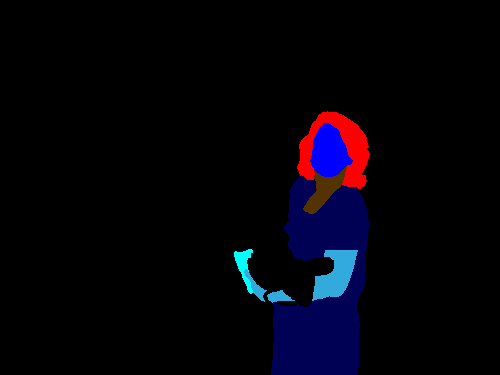

In [ ]:
# Import image as grayscale
image_path = '/content/data/val_parsing/0000001-2.png'
gray_image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
color_image = decode_labels(gray_image)
# Display the original and grayscale images
cv2_imshow(color_image)

In [ ]:
contours = create_contour(gray_image)

In [ ]:
h,w = gray_image.shape
res = ""
for cl, ct in enumerate(contours):
    for c in ct:
        line = "" + str(cl)
        for xy in c:
            x,y = xy[0]
            line = line + " " + str(x/w) + " " + str(y/h)
        line += "\n"
        res += line
f = open("0000001-2.txt", "w")
f.write(res)
f.close()

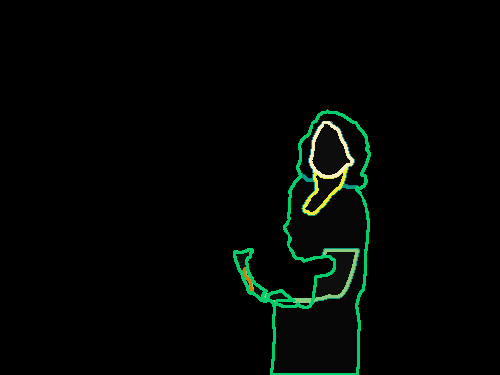

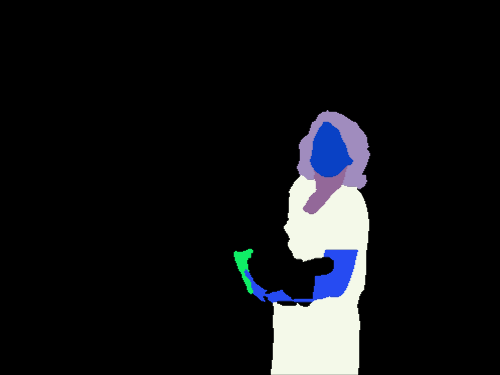

In [ ]:
draw_label_YOLOv8("/content/data/val_parsing/0000001-2.png", "/content/0000001-2.txt", False)
draw_label_YOLOv8("/content/data/val_parsing/0000001-2.png", "/content/0000001-2.txt", True)

### Test some result (2)

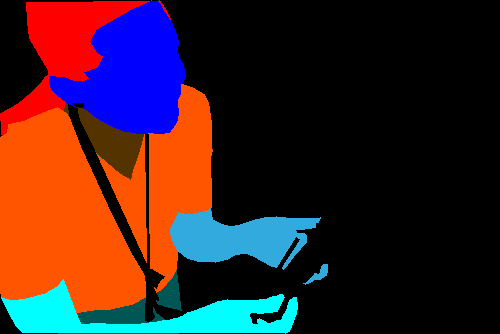

In [ ]:
# Import image as grayscale
image_path = '/content/data/train_parsing/0000012-3.png'
gray_image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
color_image = decode_labels(gray_image)
# Display the original and grayscale images
cv2_imshow(color_image)

In [ ]:
contours = create_contour(gray_image)

In [ ]:
h,w = gray_image.shape
res = ""
for cl, ct in enumerate(contours):
    for c in ct:
        line = "" + str(cl)
        for xy in c:
            x,y = xy[0]
            line = line + " " + str(x/w) + " " + str(y/h)
        line += "\n"
        res += line
f = open("0000012-3.txt", "w")
f.write(res)
f.close()

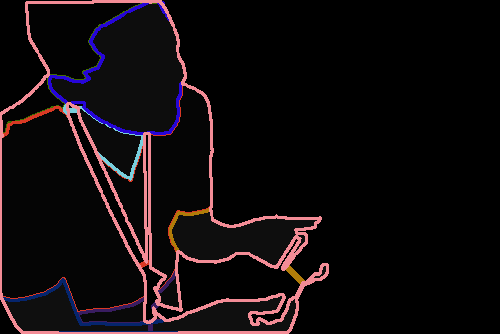

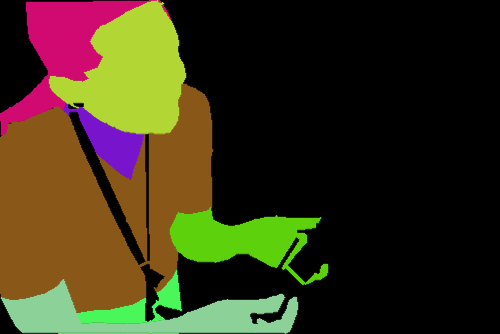

In [ ]:
draw_label_YOLOv8("/content/data/train_parsing/0000012-3.png", "/content/0000012-3.txt", False)
draw_label_YOLOv8("/content/data/train_parsing/0000012-3.png", "/content/0000012-3.txt", True)

### Test instance visualize

In [ ]:
ct = contours[20][0]

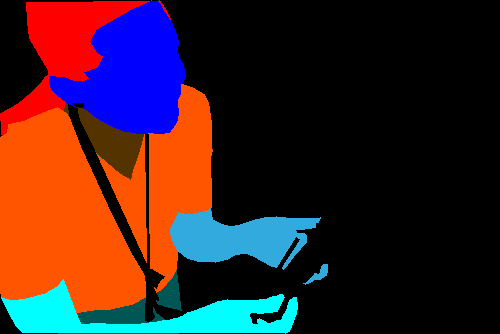

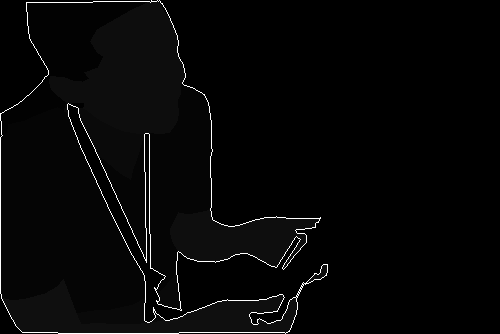

In [ ]:
clone_image = gray_image.copy()
clone_image_color = decode_labels(clone_image)
arr = np.array(ct)
arr = arr.reshape((-1, 1, 2))
isClosed = True
# White color in BGR
color = (255, 255, 255)

# Line thickness of 2 px
thickness = 1

# Using cv2.polylines() method
# Draw a White polygon with
# thickness of 1 px
res = cv2.polylines(clone_image, [arr],
                    isClosed, color, thickness)
# Displaying the image
cv2_imshow(clone_image_color)
cv2_imshow(clone_image)

# Tạo label cho toàn bộ dữ liệu

## Train

In [ ]:
import os
import multiprocessing

In [ ]:
!mkdir train
%cd train

In [ ]:
def process(file):
    if file.endswith(('.jpg', '.png', 'jpeg')):
        img_path = val_path + file
        print(img_path)
    annot_file = file.rsplit('-')[0] + ".txt"
    image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    contours = create_contour(image)
    support_create_txt(annot_file, contours, image)

In [ ]:
train_path = "/content/data/train_parsing/"

In [ ]:
train_images = os.listdir(train_path)

In [ ]:
train_images.sort()

In [ ]:
pool = multiprocessing.Pool()
pool = multiprocessing.Pool(processes=10)
outputs = pool.map(process, train_images)

In [ ]:
%cd ..

## Val

In [ ]:
import os
import multiprocessing

In [ ]:
!mkdir val
%cd val

/content/val


In [ ]:
def process(file):
    if file.endswith(('.jpg', '.png', 'jpeg')):
        img_path = val_path + file
        print(img_path)
    annot_file = file.rsplit('-')[0] + ".txt"
    image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    contours = create_contour(image)
    support_create_txt(annot_file, contours, image)

In [ ]:
val_path = "/content/data/val_parsing/"

In [ ]:
val_images = os.listdir(val_path)

In [ ]:
val_images.sort()

In [ ]:
pool = multiprocessing.Pool()
pool = multiprocessing.Pool(processes=10)
outputs = pool.map(process, val_images)

In [ ]:
%cd ..